## Download and read data

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandahouse
%matplotlib inline

In [27]:
def select(query):
    return pandahouse.read_clickhouse(query, connection=connection)

In [28]:
connection = {
    'database': 'simulator_20221120',
    'host': 'https://clickhouse.lab.karpov.courses',
    'user': 'student',
    'password': 'dpo_python_2020'
}

In [29]:
query = '''
select exp_group, user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes / views as ctr
from {db}.feed_actions 
where toDate(time) between '2022-11-02' and '2022-11-08' and exp_group in (2, 1)
group by exp_group, user_id
'''

In [30]:
df = select(query)

In [31]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


## Histogram 

<AxesSubplot:xlabel='ctr', ylabel='Count'>

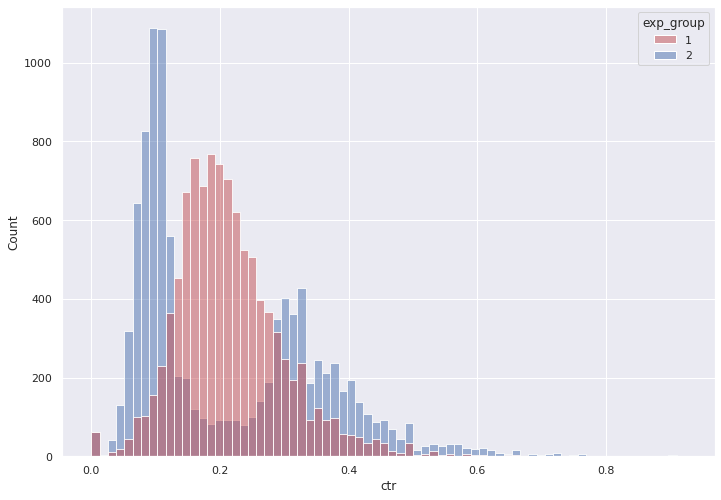

In [32]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.histplot(data=df, x='ctr', hue='exp_group', kde = False, palette=['r', 'b'], alpha=0.5)

Анализ "на глаз" и гистограмма утверждает, что отличие между группами есть. 

## Student's t-test

In [33]:
group_A = df[df['exp_group'] == 2].copy() 
group_B = df[df['exp_group'] == 1].copy()

In [34]:
stats.ttest_ind(group_A['ctr'], group_B['ctr'], equal_var=False)

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

T-test утверждает, что отличия между группами нет.

## Smothed CTR

In [9]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [37]:
global_ctr_A = df[df['exp_group'] == 2]['likes'].sum() / df[df['exp_group'] == 2]['views'].sum() 
global_ctr_B = df[df['exp_group'] == 1]['likes'].sum() / df[df['exp_group'] == 1]['views'].sum()

In [38]:
group_A['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_A, 5), axis=1) 
group_B['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_B, 5), axis=1)

In [39]:
stats.ttest_ind(group_A['smothed_ctr'], group_B['smothed_ctr'], equal_var=False)

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.0223769815558559)

Smothed CTR утверждает, что отличие между группами есть. Так как теоритичекой гарантии нет, это может быть основанием не утверждать, что отличие между группами есть. 

По какой-то причине t-test утверждает, что отличия между группами нет, возможно, это связано с тем, что разные метрики имеют разную чувствительность и мощности t-test не достаточно, чтобы выявить отличие.

## Poisson bootstrap

In [40]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [41]:
likes1 = df[df['exp_group'] == 2]['likes'].to_numpy()
views1 = df[df['exp_group'] == 2]['views'].to_numpy()

In [42]:
likes2 = df[df['exp_group'] == 1]['likes'].to_numpy()
views2 = df[df['exp_group'] == 1]['views'].to_numpy()

In [43]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

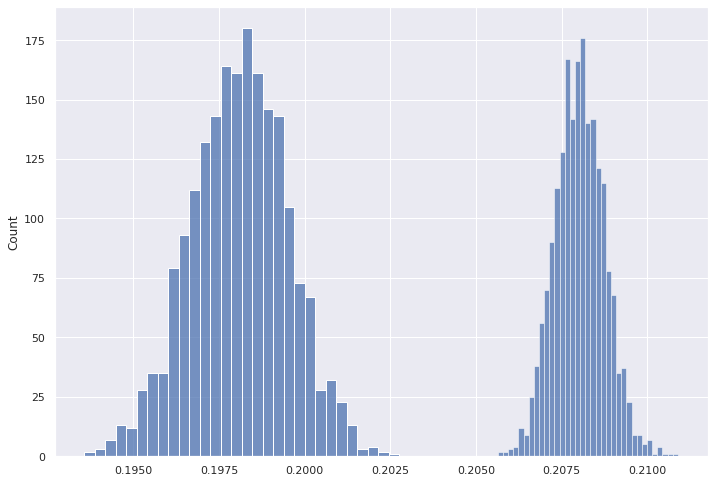

In [44]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Poisson bootstrap утверждает, что экспериментальный алгоритм статистически значимо хуже контрольного алгоритма. 

## Bucket evaluations

In [45]:
query = '''
select exp_group, xxHash64(user_id)%50 as bucket,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes / views as bucket_ctr
from {db}.feed_actions 
where toDate(time) between '2022-11-02' and '2022-11-08' and exp_group in (2, 1)
group by exp_group, bucket
'''

In [46]:
df = select(query)

In [47]:
df

,exp_group,bucket,likes,views,bucket_ctr
0,1,0,2624,13355,0.196481
1,2,0,2634,13559,0.194262
2,1,1,2681,12653,0.211887
3,2,1,2686,12474,0.215328
4,1,2,3046,14767,0.206271
...,...,...,...,...,...
95,2,47,2510,12814,0.195880
96,1,48,2839,13342,0.212787
97,2,48,2554,13131,0.194502
98,1,49,2949,14515,0.203169


In [50]:
stats.mannwhitneyu(df[df['exp_group'] == 2]['bucket_ctr'], df[df['exp_group'] == 1]['bucket_ctr'], alternative='two-sided')

MannwhitneyuResult(statistic=505.0, pvalue=2.859963936492646e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

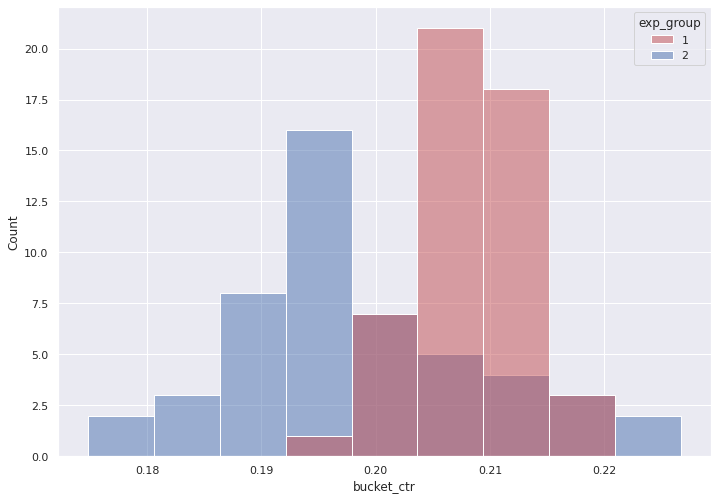

In [52]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.histplot(data=df, x='bucket_ctr', hue='exp_group', kde=False, palette=['r', 'b'], alpha=0.5)

Mann–Whitney U test и бакетное распределение показывают явное, статистически значимое отличие.

## Summary

Основываясь на данных проведенных тестов, рекомендация не использовать новый алгоритм на всех пользователях. 
Возможно, команде ML имеет смысл проводить дальнейшее исследование алгоритма, потому что характер распределения показывает, что алгоритм, условно разделил пользователей на две группы.
У одной группы CTR стал меньше, у другой группы CTR стал больше. Возможно, понимание причин такого поведения алгоритма сможет помочь команде ML его улучшить. 